In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, precision_score, f1_score, recall_score, accuracy_score
from sklearn.model_selection import train_test_split
import pickle
import time

import sys
sys.stdout = open('output_of_nb_tfidf.txt','a')

stopwords = stopwords.words('english')

#### Load data

In [2]:
X = np.load('../data/X_token.npy', allow_pickle=True)
y = np.load('../data/y_binarized.npy', allow_pickle=True) 

#word embeddings using tf-idf
tf_idf_vect = TfidfVectorizer(stop_words=None)
tf_idf_vect.fit(X)
X_final_tf_idf = tf_idf_vect.transform(X)
tfidf_feat = tf_idf_vect.get_feature_names()

X_train, X_test, y_train, y_test = train_test_split(X_final_tf_idf, y, test_size=0.4, random_state=1)
# validation set
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=1)


/Users/siddhipotdar/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [3]:
tags = np.load('../data/y_tags.npy', allow_pickle=True)

# Naive Bayes

NB multiple binary classifiers

In [4]:
def train_nb(alpha = 1, name=None):
    NB_model_list = []
    for i in range(y_train.shape[1]):
        sample_y_train = y_train[:, i]
        NB_clf_single = MultinomialNB(alpha = alpha)
        NB_clf_single.fit(X_train, sample_y_train)
        NB_model_list.append(NB_clf_single)
    with open(name, 'wb') as f:
        pickle.dump(NB_model_list, f)
    return NB_model_list

    

In [5]:
def pred_nb(model, x_data):
    return model.predict(x_data)

In [6]:
def calc_scores(name, NB_model_list):
    precision_tr = []
    precision_v = []
    recall_tr = []
    recall_v = []
    f1_tr = []
    f1_v = []
    accu_tr = []
    accu_v = []
    
    for i in range(len(NB_model_list)):
        y_pred_tr = pred_nb(NB_model_list[i], X_train)
        y_pred_v = pred_nb(NB_model_list[i] ,(X_val))

        precision_tr.append(precision_score(y_pred=y_pred_tr, y_true=y_train[:,i]))
        precision_v.append(precision_score(y_pred=y_pred_v, y_true=y_val[:,i]))

        recall_tr.append(recall_score(y_pred=y_pred_tr, y_true=y_train[:,i]))
        recall_v.append(recall_score(y_pred=y_pred_v, y_true=y_val[:,i]))

        f1_tr.append(f1_score(y_pred=y_pred_tr, y_true=y_train[:,i]))
        f1_v.append(f1_score(y_pred=y_pred_v, y_true=y_val[:,i]))

        accu_tr.append(accuracy_score(y_pred=y_pred_tr, y_true=y_train[:,i]))
        accu_v.append(accuracy_score(y_pred=y_pred_v, y_true=y_val[:,i]))

    with open("../results/precision_alpha_tr_"+name+".txt", "w") as output:
        output.write(str(y_pred_tr))
    with open("../results/precision_alpha_v_"+name+".txt", "w") as output:
        output.write(str(y_pred_v))
    with open("../results/recall_alpha_tr"+name+".txt", "w") as output:
        output.write(str(recall_tr))
    with open("../results/recall_alpha_v"+name+".txt", "w") as output:
        output.write(str(recall_v))
    with open("../results/f1_alpha_tr"+name+".txt", "w") as output:
        output.write(str(f1_tr))
    with open("../results/f1_alpha_v"+name+".txt", "w") as output:
        output.write(str(f1_v))
    with open("../results/accu_alpha_tr"+name+".txt", "w") as output:
        output.write(str(accu_tr))
    with open("../results/accu_alpha_v"+name+".txt", "w") as output:
        output.write(str(accu_v))
    
    return precision_tr, precision_v, recall_tr, recall_v, f1_tr, f1_v, accu_tr, accu_v

In [7]:
def plotting_metrics(metric_list, name, tags=tags):
    disp_df = pd.DataFrame(
        {'tags': tags,
        'prec': metric_list
        })
    disp_df = disp_df.sort_values(by = 'prec' , ascending=False)
    # plt.xticks(fontsize=10)
    plt.figure(figsize=(300, 200), dpi=200)
    plt.bar(disp_df['tags'], disp_df['prec'])
    plt.savefig(name)

alpha (smoothening parameter) = 1

In [23]:
start_time = time.time()
NB_model_list_large_alpha = train_nb(alpha=1, name='../models/nb_large_alpha_model_list_tfidf.pkl')
print('Execution time for NB with alpha = 1, for tf-idf embeddings',time.time()-start_time)


alpha (smoothening parameter) = 0.01

In [24]:
start_time = time.time()
NB_model_list_med_alpha = train_nb(alpha=0.01, name='../models/nb_med_alpha_model_list_tfidf.pkl')
print('Execution time for NB with alpha = 0.01, for tf-idf embeddings',time.time()-start_time)


alpha (smoothening parameter) = 0.0001

In [25]:
start_time = time.time()
NB_model_list_small_alpha = train_nb(alpha=0.0001,name='../models/nb_small_alpha_model_list_tfidf.pkl')
print('Execution time for NB with alpha 0.0001, for tf-idf embeddings',time.time()-start_time)


Trained models can be loaded using the following lines

In [13]:
# NB_model_list_large_alpha = pickle.load(open('../models/nb_large_alpha_model_list_tfidf.pkl', 'rb'))
# NB_model_list_med_alpha = pickle.load(open('../models/nb_med_alpha_model_list_tfidf.pkl', 'rb'))
NB_model_list_small_alpha = pickle.load(open('../models/nb_small_alpha_model_list_tfidf.pkl', 'rb'))

Calculating evaluation metrics for NB with alpha = 1

In [10]:
precision_large_alpha_tr, precision_large_alpha_v,recall_large_alpha_tr,recall_large_alpha_v, f1_large_alpha_tr, f1_large_alpha_v, accu_large_alpha_tr, accu_large_alpha_v = calc_scores('large_alpha',NB_model_list_large_alpha)
f1_mean_large_alpha_tr = np.mean(f1_large_alpha_tr)
accu_mean_large_alpha_tr = np.mean(accu_large_alpha_tr)
print("F1 mean for large alpha, nb, tfidf: ", f1_mean_large_alpha_tr)
print("accuracy mean for large alpha, nb, tfidf: ", accu_mean_large_alpha_tr)

/Users/siddhipotdar/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/siddhipotdar/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/siddhipotdar/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/siddhipotdar/opt/anaconda3/lib/python3.9/site-packages

Calculating evaluation metrics for NB with alpha = 0.01

In [11]:
precision_med_alpha_tr, precision_med_alpha_v,recall_med_alpha_tr,recall_med_alpha_v, f1_med_alpha_tr, f1_med_alpha_v, accu_med_alpha_tr, accu_med_alpha_v = calc_scores('med_alpha',NB_model_list_med_alpha)
f1_mean_med_alpha_tr = np.mean(f1_med_alpha_tr)
accu_mean_med_alpha_tr = np.mean(accu_med_alpha_tr)
print("F1 mean for med alpha, nb, tfidf: ", f1_mean_med_alpha_tr)
print("accuracy mean for med alpha, nb, tfidf ", accu_mean_med_alpha_tr)

Calculating evaluation metrics for NB with alpha = 0.0001

In [14]:
precision_small_alpha_tr, precision_small_alpha_v,recall_small_alpha_tr,recall_small_alpha_v, f1_small_alpha_tr, f1_small_alpha_v, accu_small_alpha_tr, accu_small_alpha_v = calc_scores('self',NB_model_list_small_alpha)
f1_mean_small_alpha_tr = np.mean(f1_small_alpha_tr)
accu_mean_small_alpha_tr = np.mean(accu_small_alpha_tr)
print("F1 mean for small alpha, nb, tfidf ", f1_mean_small_alpha_tr)
print("accuracy mean for small alpha, nb, tfidf ", accu_mean_small_alpha_tr)

Plot for train vs val

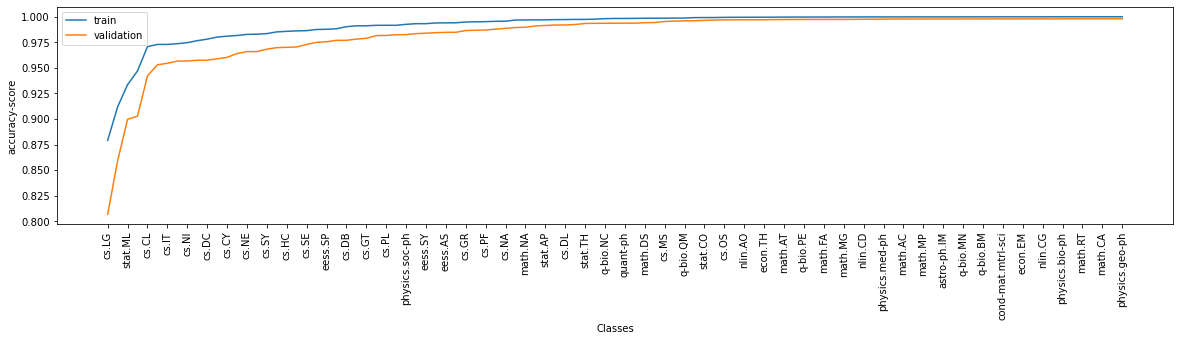

In [15]:
plt.close("all")
fig, ax = plt.subplots(figsize = (20, 4))
sorted_f1 = np.sort(accu_small_alpha_tr)
new_tags = tags[np.argsort(accu_small_alpha_tr)]
idx = np.arange(len(new_tags))
width = 0.5
ax.plot(sorted(accu_small_alpha_tr))
ax.plot(sorted(accu_small_alpha_v))

xticks_idx = idx[::2]

ax.set_xticks(xticks_idx)
ax.set_xticklabels([new_tags[x] for x in xticks_idx], rotation=90)
ax.set_ylabel("accuracy-score")
ax.set_xlabel("Classes")
ax.legend(['train', 'validation'])
#plt.yscale("log")
plt.show()
fig.savefig("small_nb_tf-plot.pdf", bbox_inches="tight")

Min / max tags accuracy

In [10]:
precision_test = []
recall_test = []
f1_test = []
accu_test = []
for i in range(len(NB_model_list_small_alpha)):
    y_pred_test = pred_nb(NB_model_list_small_alpha[i],X_test)
    precision_test.append(precision_score(y_pred=y_pred_test, y_true=y_test[:,i]))
    recall_test.append(recall_score(y_pred=y_pred_test, y_true=y_test[:,i]))
    f1_test.append(f1_score(y_pred=y_pred_test, y_true=y_test[:,i]))
    accu_test.append(accuracy_score(y_pred=y_pred_test, y_true=y_test[:,i]))
print("accuracy for test: ", np.mean(accu_test))
print("f1_test for test: ", np.mean(f1_test))

In [11]:
print("Minimum accuracy: ", min(accu_test))
print("Tag: ",tags[np.argmin(accu_test)])


In [12]:
print("Minimum accuracy: ", max(accu_test))
print("Tag: ",tags[np.argmax(accu_test)])

Confusion matrix for the best model:

In [13]:
from sklearn.metrics import ConfusionMatrixDisplay
idx_good = np.where(tags=='cs.LG')[0][0]
idx_avg = np.where(tags=='cs.NE')[0][0]
idx_bad = np.where(tags=='cs.NA')[0][0]
print(idx_avg)
y_pred_v_good = NB_model_list_small_alpha[idx_good].predict(X_test)
y_pred_v_avg = NB_model_list_small_alpha[idx_avg].predict(X_test)
y_pred_v_bad = NB_model_list_small_alpha[idx_bad].predict(X_test)

m_good = confusion_matrix(y_pred=y_pred_v_good, y_true=y_test[:,idx_good])
m_avg = confusion_matrix(y_pred=y_pred_v_avg, y_true=y_test[:,idx_avg])
m_bad = confusion_matrix(y_pred=y_pred_v_bad, y_true=y_test[:,idx_bad])


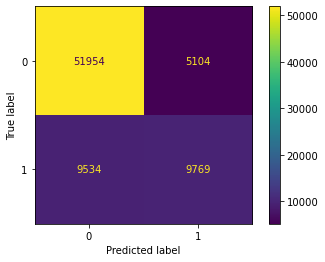

In [16]:
plt_good = ConfusionMatrixDisplay(m_good).plot()

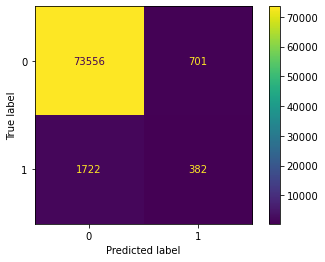

In [17]:
plt_avg = ConfusionMatrixDisplay(m_avg).plot()

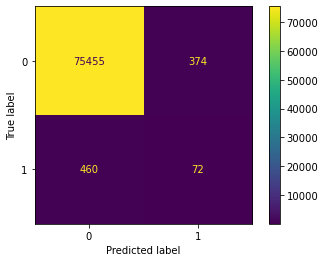

In [19]:
plt_bad = ConfusionMatrixDisplay(m_bad).plot()

In [11]:
plotting_metrics(recall_small_alpha_v, './results/recall_small_alpha_v.png')
plotting_metrics(f1_small_alpha_v, './results/f1_small_alpha_v.png')
plotting_metrics(precision_small_alpha_v, './results/precision_small_alpha_v.png')